Mathilde Koch, INRA, Faulon's group.

The aim of this script is to generate results presented in Figure 1e of accompanying paper.

# Importing necessary libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import sklearn
# from sklearn import linear_model
from sklearn import decomposition
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold

import random
import csv
import copy

import warnings

In [2]:
folder_for_data = "data/no_controls"  # Data from the study, without the control points of lines A and P. 
folder_to_save = "model_statistics"
random.seed(42)  # For data reproductibility

# Importing data from the study

In [3]:
plate_1 = "{}/plate_AL_1_raw_yield_and_std.csv".format(folder_for_data)
plate_1_array = np.genfromtxt(plate_1, delimiter=',', skip_header = 1,dtype = "float")

plate_2 = "{}/plate_AL_2_raw_yield_and_std.csv".format(folder_for_data)
plate_2_array = np.genfromtxt(plate_2, delimiter=',', skip_header = 1,dtype = "float")

plate_3 = "{}/plate_AL_3_raw_yield_and_std.csv".format(folder_for_data)
plate_3_array = np.genfromtxt(plate_3, delimiter=',', skip_header = 1,dtype = "float")

plate_4 = "{}/plate_AL_4_raw_yield_and_std.csv".format(folder_for_data)
plate_4_array = np.genfromtxt(plate_4, delimiter=',', skip_header = 1,dtype = "float")

plate_5 = "{}/plate_AL_5_raw_yield_and_std.csv".format(folder_for_data)
plate_5_array = np.genfromtxt(plate_5, delimiter=',', skip_header = 1,dtype = "float")

plate_6 = "{}/plate_AL_6_raw_yield_and_std.csv".format(folder_for_data)
plate_6_array = np.genfromtxt(plate_6, delimiter=',', skip_header = 1,dtype = "float")

plate_7 = "{}/plate_AL_7_raw_yield_and_std.csv".format(folder_for_data)
plate_7_array = np.genfromtxt(plate_7, delimiter=',', skip_header = 1,dtype = "float")

plate_8 = "{}/plate_AL_8_raw_yield_and_std.csv".format(folder_for_data)
plate_8_array = np.genfromtxt(plate_8, delimiter=',', skip_header = 1,dtype = "float")

plate_9 = "{}/plate_AL_9_raw_yield_and_std.csv".format(folder_for_data)
plate_9_array = np.genfromtxt(plate_9, delimiter=',', skip_header = 1,dtype = "float")

plate_10 = "{}/plate_AL_10_raw_yield_and_std.csv".format(folder_for_data)
plate_10_array = np.genfromtxt(plate_10, delimiter=',', skip_header = 1,dtype = "float")

# Defining necessary functions

In [4]:
def present_in_array_index(new_sample, array, size = 11):
    """
    Verify if a sample is present in an array.
    """
    present = False
    new_sample = np.reshape(np.array(new_sample), (1,size))
    for i in range(array.shape[0]):
        if np.array_equiv(array[i,:],new_sample):
            present = True
            break
    return(present, i)

In [5]:
def select_current_best_model(X, y, models_number = 10, 
                              verbose = False, 
                             MLP = True,
                             visu = False,
                             model_name = "test"):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

    trained_model_list = []
    # Training all models
    for i in range(models_number):
        X_train, y_train = X, y
        if MLP:
            other_MLP = MLPRegressor(hidden_layer_sizes  = (10, 100,100, 20), solver ="adam", max_iter=20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            other_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(other_MLP)

            big_MLP = MLPRegressor(hidden_layer_sizes  = (100,100, 20),solver ="adam", max_iter=20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            big_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(big_MLP)


            medium_MLP = MLPRegressor(hidden_layer_sizes  = (40, 10), solver ="adam", max_iter=20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            medium_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(medium_MLP)
  
            small_MLP = MLPRegressor(hidden_layer_sizes  = (10), solver ="adam", max_iter=20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            small_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(small_MLP)
        
    # Evaluating all 
    all_scores = []
    for i in range(len(trained_model_list)):
        selected_mdoel = trained_model_list[i]
        y_pred = selected_mdoel.predict(X)
        score = sklearn.metrics.r2_score(y, y_pred)
        all_scores.append(score)

    try:
        best_index = all_scores.index(max(all_scores))
        best_score = all_scores[best_index]
    except ValueError:
        best_index = 0
    if verbose:
        print(all_scores)
        print("Best index is {}".format(best_index))
        print("Best score is {}".format(best_score))
    best_model = trained_model_list[best_index]
    if visu:        
        model = best_model
        y_pred = model.predict(X)
        score = sklearn.metrics.r2_score(y, y_pred)
        fig, ax = plt.subplots()
        ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_title("Model prediction for model {}: {}".format(model_name, score))
        ax.set_ylabel('Predicted')
        plt.show()
    return(best_model, best_score)

In [6]:
def obtain_global_score(X_data, y_data, y_std_data, iteration_number, folder_to_save, 
                        ensemble_size = 25, nbr_fold = 5, models_number_repeat = 10):
    dictionnary_of_models = {2:0, 3:0, 4:0, 5:0, 6:0}  # Extract model number of layers.
    kf = KFold(n_splits=nbr_fold, shuffle = True)
    scores_on_folds = []
    fold_number = 0
    for train_index, test_index in kf.split(X_data):
        fold_number = fold_number + 1
        X_train, X_test = X_data[train_index], X_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        y_std_train, y_std_test = y_std_data[train_index], y_std_data[test_index]
        
        # Training ensemble models
        ensemble_models = []
        for n in range(ensemble_size):
            current_best, best_score = select_current_best_model(X_train, y_train,
                                                                models_number = models_number_repeat, verbose = False, 
                                                                 MLP = True,
                                                                 visu = False,
                                                                model_name = n)
            ensemble_models.append(current_best)
        # Analysing the models:
        for model in ensemble_models:
            dictionnary_of_models[model.n_layers_] = dictionnary_of_models[model.n_layers_] + 1
        print(dictionnary_of_models)
        # Evaluating the models
        all_predictions = None
        for model in ensemble_models:
            y_pred = model.predict(X_test)
            answer_array_pred = y_pred.reshape(X_test.shape[0], -1)
            if all_predictions is None:
                all_predictions = y_pred.reshape(X_test.shape[0], -1)
            else:
                all_predictions =np.concatenate((all_predictions, y_pred.reshape(X_test.shape[0], -1)), axis = 1)

        y_pred, y_pred_std = np.mean(all_predictions, axis = 1), np.std(all_predictions, axis = 1)
        score = sklearn.metrics.r2_score(y_test, y_pred)
        fig, ax = plt.subplots()
        ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
        ax.errorbar(y_test, y_pred, xerr = y_std_test, yerr = y_pred_std, ls='none')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_title("R squared is: {}".format(score))
        ax.set_ylabel('Predicted')
        name_for_plotting = folder_to_save + '/' + "iteration_{}".format(iteration_number) + "fold_{}".format(fold_number) +'.png'
        plt.savefig(name_for_plotting)
        plt.show()
        scores_on_folds.append(score)
    global_score = np.mean(scores_on_folds)
    global_score_std = np.std(scores_on_folds)
    
    return(global_score, global_score_std)

In [7]:
def data_from_iteration(iteration_number = 1):
    """
    Obtain data from the desired number of iterations, and not the whole data.
    """
    full_plates_list = [plate_1_array, plate_2_array, plate_3_array, plate_4_array, plate_5_array,
                        plate_6_array, plate_7_array, plate_8_array, plate_9_array, plate_10_array]
    selected_plates = full_plates_list[0:iteration_number]
    current_data = np.concatenate(selected_plates, axis = 0)
    return(current_data)

# Running iteration tests - small scale

This test uses small scale parameters:
- model ensemble of size 3
- cross fold validation of 5
- repeating model training twice

Pleaase create a "models_statistics_small" folder to see this small example.

{2: 0, 3: 2, 4: 1, 5: 0, 6: 0}


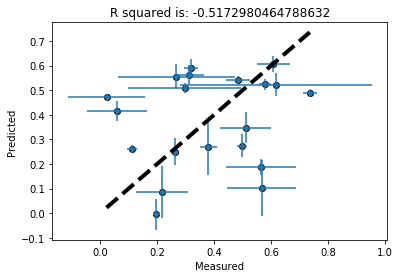

{2: 0, 3: 3, 4: 3, 5: 0, 6: 0}


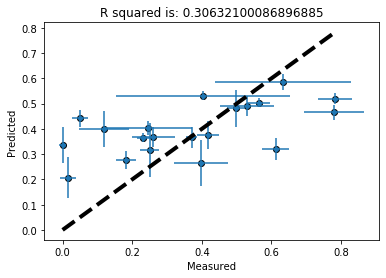

{2: 0, 3: 5, 4: 3, 5: 0, 6: 1}


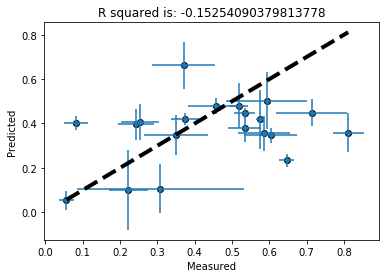

{2: 0, 3: 6, 4: 5, 5: 0, 6: 1}


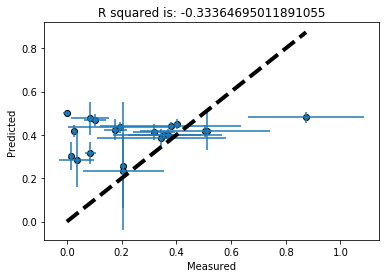

{2: 0, 3: 6, 4: 8, 5: 0, 6: 1}


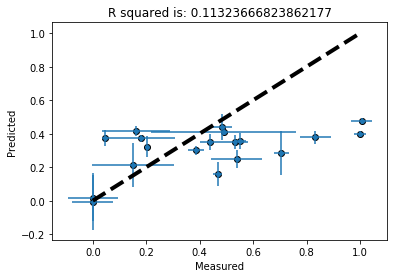

For iteration 1, global score is (-0.11678564625766419, 0.29686594492939095)
{2: 0, 3: 0, 4: 2, 5: 1, 6: 0}


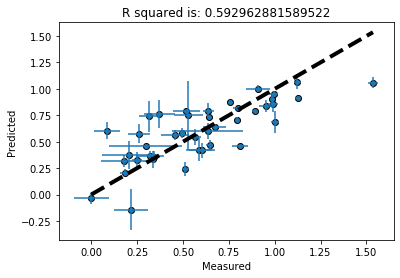

{2: 0, 3: 0, 4: 3, 5: 3, 6: 0}


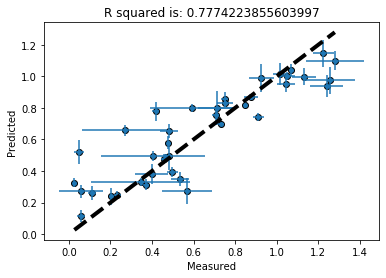

{2: 0, 3: 0, 4: 5, 5: 4, 6: 0}


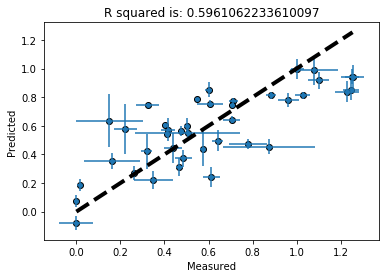

{2: 0, 3: 1, 4: 7, 5: 4, 6: 0}


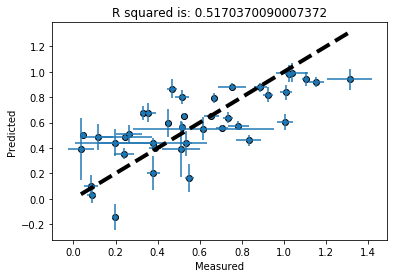

{2: 0, 3: 2, 4: 8, 5: 4, 6: 1}


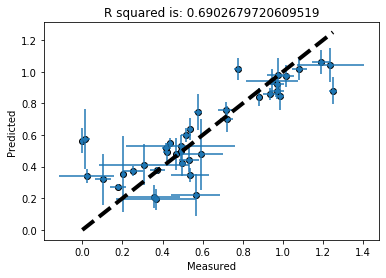

For iteration 2, global score is (0.634759294314524, 0.0900372227240518)
{2: 0, 3: 0, 4: 2, 5: 1, 6: 0}


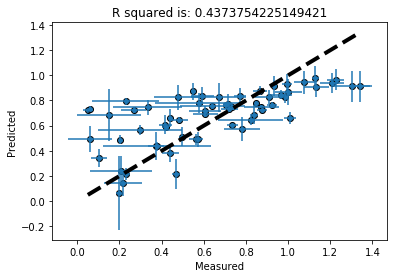

{2: 0, 3: 1, 4: 3, 5: 2, 6: 0}


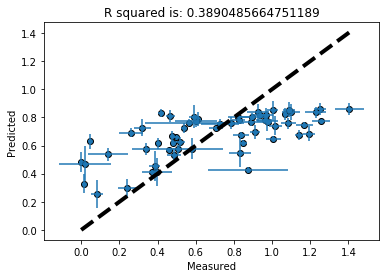

{2: 0, 3: 1, 4: 4, 5: 4, 6: 0}


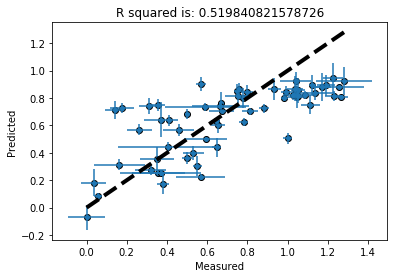

{2: 0, 3: 1, 4: 6, 5: 5, 6: 0}


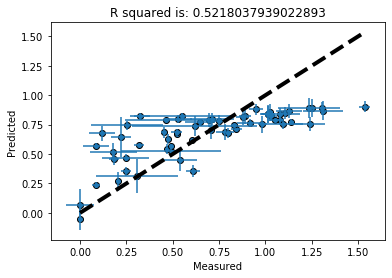

{2: 0, 3: 1, 4: 7, 5: 7, 6: 0}


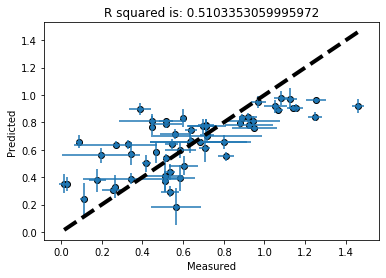

For iteration 3, global score is (0.4756807820941347, 0.0533869247816373)
{2: 0, 3: 0, 4: 0, 5: 3, 6: 0}


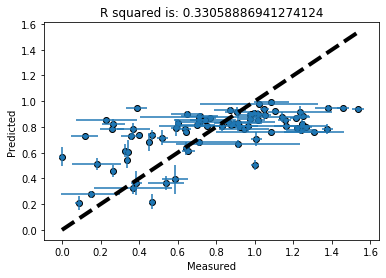

{2: 0, 3: 0, 4: 1, 5: 5, 6: 0}


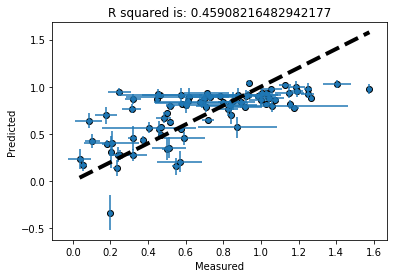

{2: 0, 3: 1, 4: 3, 5: 5, 6: 0}


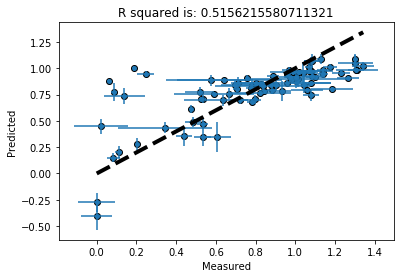

{2: 0, 3: 1, 4: 4, 5: 7, 6: 0}


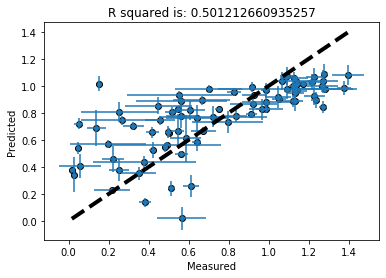

{2: 0, 3: 1, 4: 7, 5: 7, 6: 0}


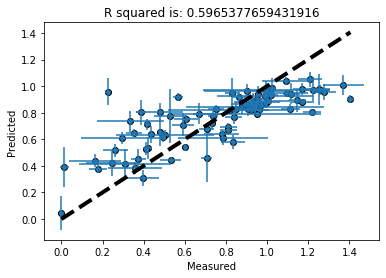

For iteration 4, global score is (0.4806086038383487, 0.08724598908010091)
{2: 0, 3: 0, 4: 2, 5: 1, 6: 0}


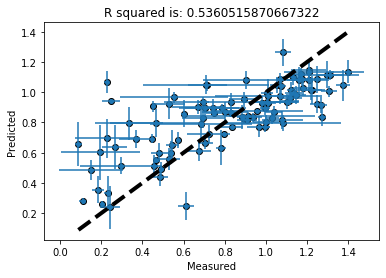

{2: 0, 3: 1, 4: 4, 5: 1, 6: 0}


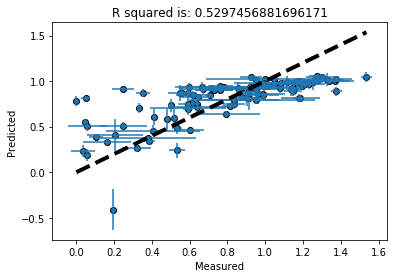

{2: 0, 3: 2, 4: 6, 5: 1, 6: 0}


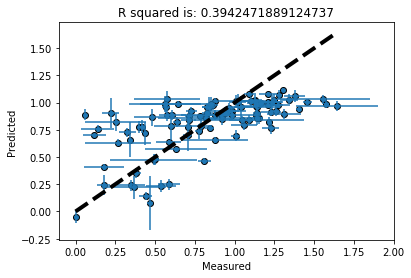

{2: 0, 3: 3, 4: 7, 5: 2, 6: 0}


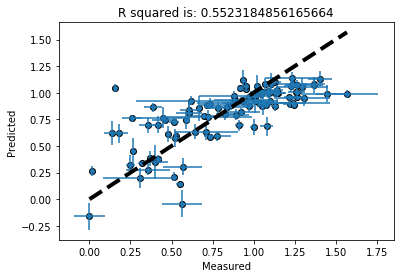

{2: 0, 3: 3, 4: 9, 5: 2, 6: 1}


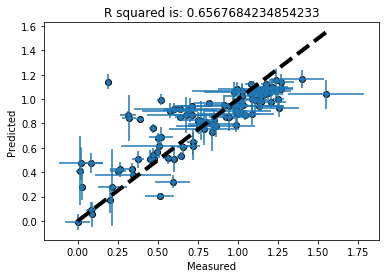

For iteration 5, global score is (0.5338262746501625, 0.08361896699123117)
{2: 0, 3: 0, 4: 1, 5: 2, 6: 0}


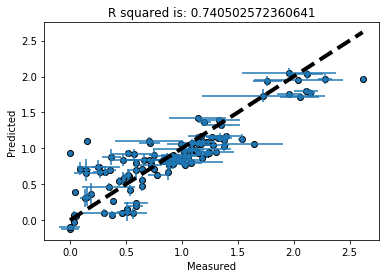

{2: 0, 3: 0, 4: 1, 5: 4, 6: 1}


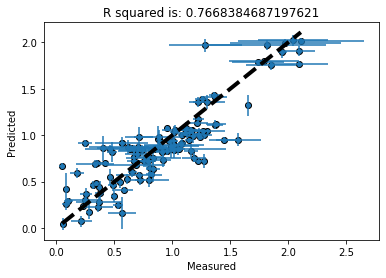

{2: 0, 3: 1, 4: 1, 5: 6, 6: 1}


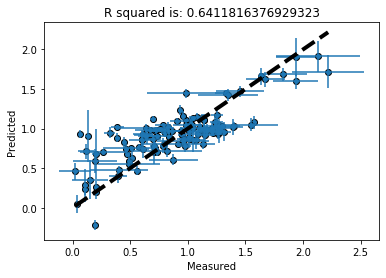

{2: 0, 3: 1, 4: 1, 5: 9, 6: 1}


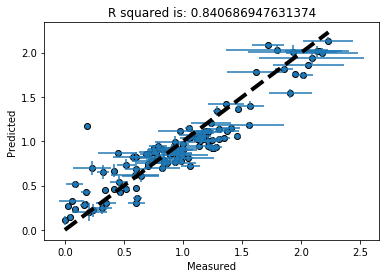

{2: 0, 3: 2, 4: 1, 5: 11, 6: 1}


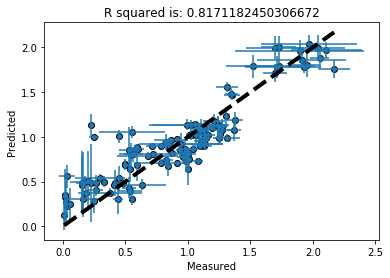

For iteration 6, global score is (0.7612655742870753, 0.06972745026513977)
{2: 0, 3: 0, 4: 1, 5: 2, 6: 0}


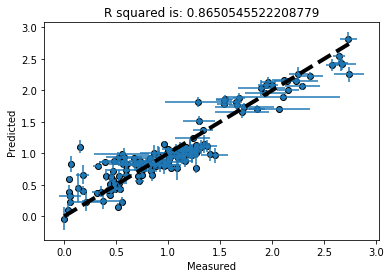

{2: 0, 3: 0, 4: 1, 5: 5, 6: 0}


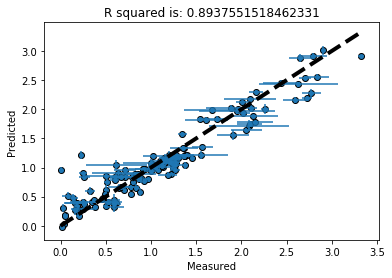

{2: 0, 3: 0, 4: 2, 5: 7, 6: 0}


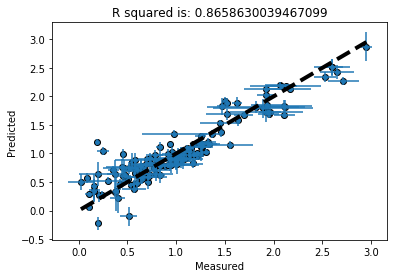

{2: 0, 3: 0, 4: 2, 5: 9, 6: 1}


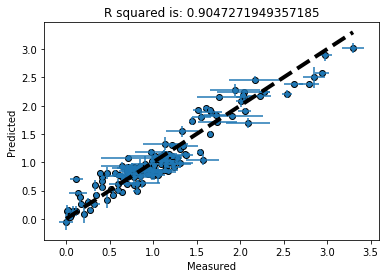

{2: 0, 3: 0, 4: 2, 5: 10, 6: 3}


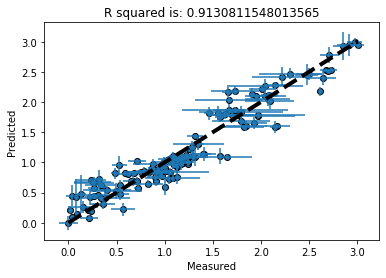

For iteration 7, global score is (0.8884962115501793, 0.019785318738375093)
{2: 0, 3: 0, 4: 1, 5: 2, 6: 0}


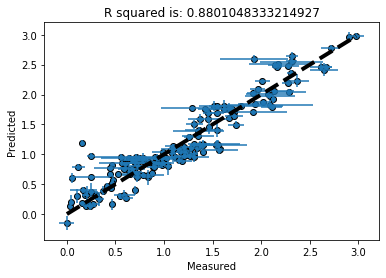

{2: 0, 3: 0, 4: 1, 5: 5, 6: 0}


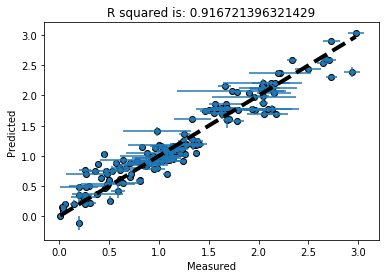

{2: 0, 3: 0, 4: 1, 5: 8, 6: 0}


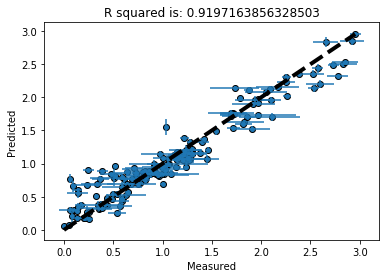

{2: 0, 3: 0, 4: 1, 5: 11, 6: 0}


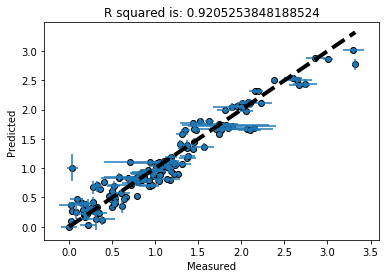

{2: 0, 3: 0, 4: 2, 5: 13, 6: 0}


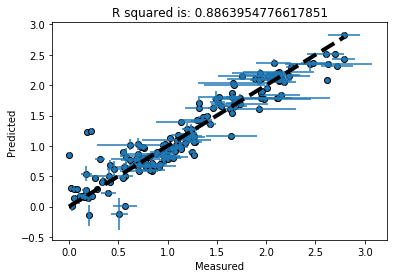

For iteration 8, global score is (0.904692695551282, 0.017665933922977373)
{2: 0, 3: 0, 4: 0, 5: 3, 6: 0}


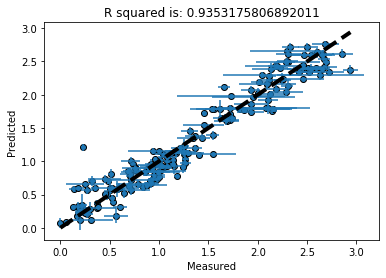

{2: 0, 3: 0, 4: 0, 5: 6, 6: 0}


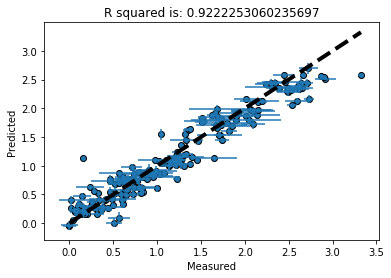

{2: 0, 3: 0, 4: 0, 5: 9, 6: 0}


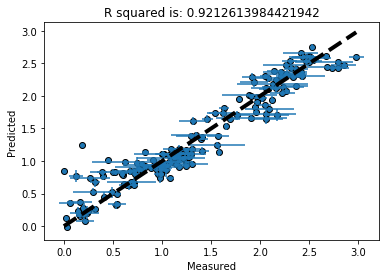

{2: 0, 3: 0, 4: 0, 5: 12, 6: 0}


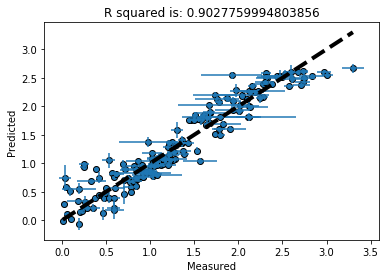

{2: 0, 3: 0, 4: 2, 5: 13, 6: 0}


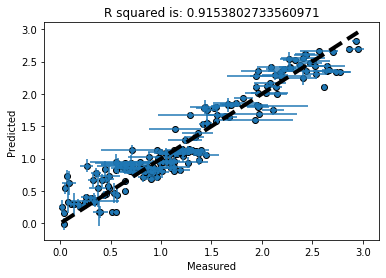

For iteration 9, global score is (0.9193921115982896, 0.010557763188460776)
{2: 0, 3: 0, 4: 1, 5: 2, 6: 0}


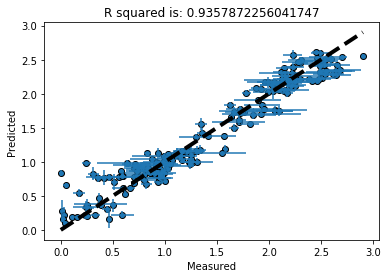

{2: 0, 3: 0, 4: 1, 5: 5, 6: 0}


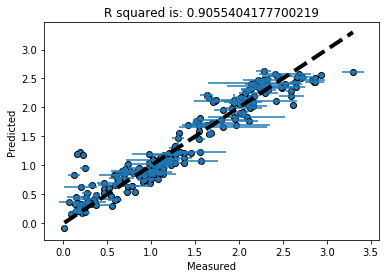

{2: 0, 3: 0, 4: 3, 5: 6, 6: 0}


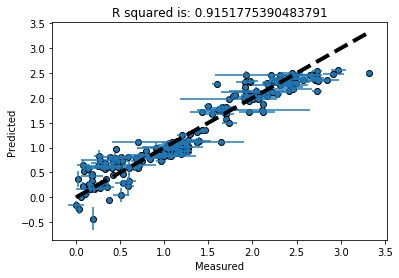

{2: 0, 3: 0, 4: 3, 5: 9, 6: 0}


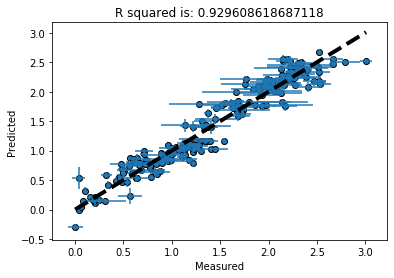

{2: 0, 3: 0, 4: 4, 5: 11, 6: 0}


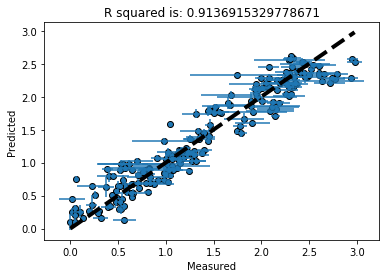

For iteration 10, global score is (0.9199610668175122, 0.011078690089110662)


In [8]:
iteration_results = {}
for iteration in range(1,11):
    # Obtain data for the desired number of iterations
    data = data_from_iteration(iteration)
    X_data, y_data, y_std_data = data[:, 0:11], data[:, 11], data[:, 12]
    for i in range(X_data.shape[1]):
        X_data[:,i] = X_data[:,i]/max(X_data[:,i])
    # Obtain score
    global_score, global_score_std = obtain_global_score(X_data, y_data, y_std_data, iteration_number = iteration, 
                               folder_to_save = "models_statistics_small",
                                ensemble_size = 3, nbr_fold = 5, models_number_repeat = 2)
    iteration_results["{}".format(iteration)] = global_score, global_score_std
    print("For iteration {}, global score is ({}, {})".format(iteration, global_score, global_score_std))


In [9]:
# For information, visualise results before saving.
print(iteration_results)

{'1': (-0.11678564625766419, 0.29686594492939095), '2': (0.634759294314524, 0.0900372227240518), '3': (0.4756807820941347, 0.0533869247816373), '4': (0.4806086038383487, 0.08724598908010091), '5': (0.5338262746501625, 0.08361896699123117), '6': (0.7612655742870753, 0.06972745026513977), '7': (0.8884962115501793, 0.019785318738375093), '8': (0.904692695551282, 0.017665933922977373), '9': (0.9193921115982896, 0.010557763188460776), '10': (0.9199610668175122, 0.011078690089110662)}


In [10]:
with open("{}/iteration_results_small.csv".format("models_statistics_small"), "w") as csv_writer:
    field_names = ["iteration", "score", "scores_std"]
    writer = csv.DictWriter(csv_writer, field_names)
    writer.writeheader()
    for key, value in iteration_results.items():
        row = {}
        global_score, global_score_std = value
        row["score"] = global_score
        row["scores_std"] = global_score_std
        row["iteration"] = key
        writer.writerow(row)

# Running model evaluation - Fig 1.e

The parameters used to generate results from Fig 1.e are:
- model ensemble of size 25
- cross fold validation of 5
- repeating model training: 10 times
Warning: this will take a couple of hours.

In [12]:
iteration_results = {}
for iteration in range(1,11):
    # Obtain data for the desired number of iterations
    data = data_from_iteration(iteration)
    X_data, y_data, y_std_data = data[:, 0:11], data[:, 11], data[:, 12]
    for i in range(X_data.shape[1]):
        X_data[:,i] = X_data[:,i]/max(X_data[:,i])
    # Obtain score
    global_score, global_score_std = obtain_global_score(X_data, y_data, y_std_data, iteration_number = iteration, 
                               folder_to_save = folder_to_save,
                                ensemble_size = 25, nbr_fold = 5, models_number_repeat = 10)
    iteration_results["{}".format(iteration)] = global_score, global_score_std
    print("For iteration {}, global score is ({}, {})".format(iteration, global_score, global_score_std))


/home/mkoch/miniconda3/envs/al/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/mkoch/miniconda3/envs/al/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/mkoch/miniconda3/envs/al/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/mkoch/miniconda3/envs/al/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


AttributeError: 'MLPRegressor' object has no attribute '_best_coefs'

In [ ]:
# For information, visualise results before saving.
print(iteration_results)

In [ ]:
with open("{}/iteration_results.csv".format(folder_to_save), "w") as csv_writer:
    field_names = ["iteration", "score", "scores_std"]
    writer = csv.DictWriter(csv_writer, field_names)
    writer.writeheader()
    for key, value in iteration_results.items():
        row = {}
        global_score, global_score_std = value
        row["score"] = global_score
        row["scores_std"] = global_score_std
        row["iteration"] = key
        writer.writerow(row)